In [1]:

%load_ext autoreload
%autoreload 2

from ETL import *
from yahist import Hist1D

from yahist.fit import fit_hist
from yahist.utils import ignore_division_errors
import scipy
import os
import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import style
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
style.use('seaborn-white')

In [73]:
module_y = 56.5
module_x = 43.1

sensor_y = 21.6
sensor_x = 21.4
sensor_gap = 0.25

disk_inner = 315
disk_outer = 1185 #1185

PB_y = 29.5
PB_x = module_x

s = Sensor(sensor_x, sensor_y)
m = Module(module_x, module_y, n_sensor_x=2, n_sensor_y=2, sensor_distance_y=sensor_y+sensor_gap, sensor_distance_x=sensor_x+sensor_gap)
m.populate(s)
rb = ReadoutBoard(10, module_y, color='green')
pb = ReadoutBoard(PB_x,PB_y, color='red')

SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

# large_sensor['D2'] = Dee(315, 1185)
# large_sensor['D2'].populate(SM, center_PB=True)

In [74]:
dee = Dee(315, 1185)
dee.populate(SM, center_PB=True)

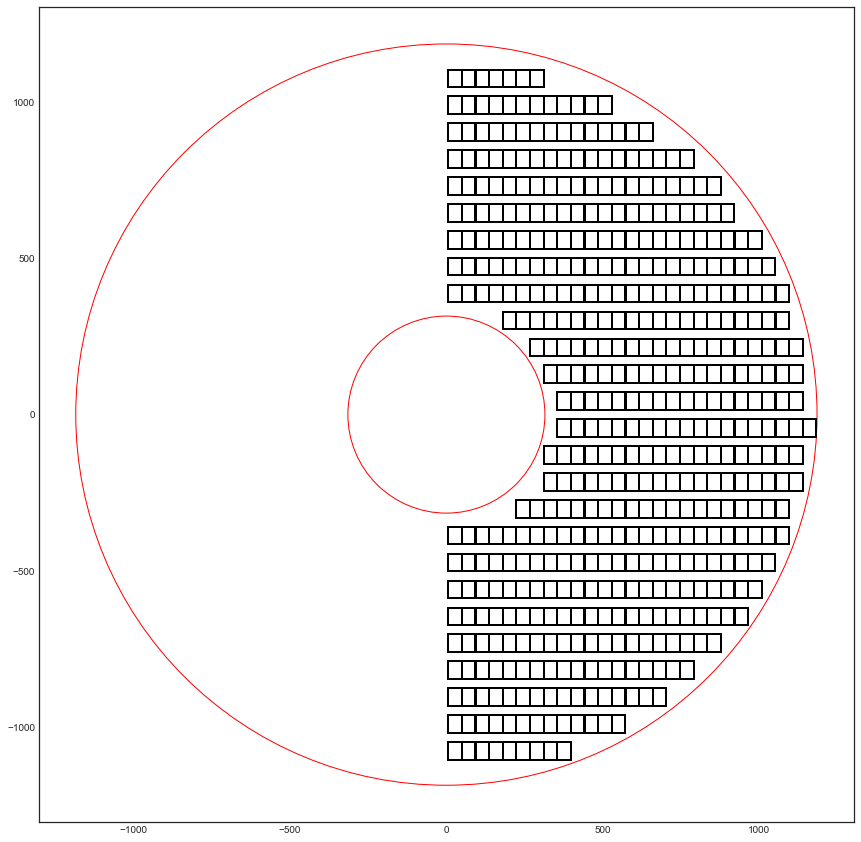

In [76]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

n_modules = 0
for sm in dee.supermodules:
    for mod in sm.modules:
        plt.gca().add_patch(mod.getPolygon())
        
    
        # for sen in mod.sensors:
        #     plt.gca().add_patch(sen.getPolygon())

plt.axis('scaled')
plt.show()

In [41]:
n_modules = 0
for sm in dee.supermodules:
    n_modules += len(sm.modules)

n_modules

490

In [47]:
n_modules_700 = 0

for sm in dee.supermodules:
    for mod in sm.modules:
        if mod.x2 < 700 and mod.y2 < 700:
            n_modules_700 += 1
            

n_modules_700

255

In [48]:
n_rb = 0
for sm in dee.supermodules:
    n_rb += 1

n_rb

80

In [4]:
def get_counts(path_file, size_x=43.1, size_y=56.5, max_radius=1185):
    df = pd.read_csv(path_file, sep='\t')
    data = {}
    data['n_modules'] = len(df[df.columns[0]])
    mod_max_radius = 0
    for x,y in zip(df['X'],df['Y']):
        try:
            x,y = float(x),float(y)
            x1 = x - size_x/2
            x2 = x + size_x/2
            y1 = y - size_y/2
            y2 = y + size_y/2
            outline = [
            [x1, y2],
            [x2, y2],
            [x2, y1],
            [x1, y1]
        ]
            outline = np.sum(np.square(np.array(outline)),axis=1)
            if (outline < max_radius**2).all():
                mod_max_radius += 1
        except:
            pass
  
    data[f'modules<{max_radius}'] = mod_max_radius
    return data

def all_counts(path_dir,size_x=43.1,size_y=56.5,max_radius=1185):
    data = []
    names = []
    for name in os.listdir(path_dir):
        names.append(name)
        path = f'{path_dir}/{name}'
        counts = get_counts(path_file=path,size_x=size_x,size_y=size_y,max_radius=max_radius)
        data.append(counts)

    df = pd.DataFrame(data,index=names)
    return df

all_counts('data',max_radius=800)

,n_modules,modules<800
Face 1 filled.txt,906,356
Face 1.txt,902,352
Face 2 filled.txt,898,360
Face 2.txt,894,356
Face 3 filled.txt,906,356
Face 3.txt,902,352
Face 4 filled.txt,898,360
Face 4.txt,894,356


In [29]:
files = [file for file in os.listdir('data') if 'filled' not in file]

for file in files:
    path = f"data/{file}"
    df = pd.read_csv(path,sep='\t')
    centers = list(zip(df['X'],df['Y']))
    
    if 'Face 4' not in file:
        new_centers = []
        for x,y in centers:
            try:
                x,y = float(x),float(y)
                new_centers.append((x,y))
            except:
                pass
        df2 = pd.DataFrame(np.array(new_centers),columns=['X','Y'])
        df2.to_csv(f"{file}")
    
    else:
        new_centers = []
        for x,y in centers:
            try:
                x,y = float(x),float(y)
                x1 = x - 43.1/2
                x2 = x + 43.1/2
                y1 = y - 56.5/2
                y2 = y + 56.5/2
                outline = [
                [x1, y2],
                [x2, y2],
                [x2, y1],
                [x1, y1]
            ]
                outline = np.sum(np.square(np.array(outline)),axis=1)
                if (outline < 800**2).all():
                    new_centers.append((x,y))
            except:
                pass
        df2 = pd.DataFrame(np.array(new_centers),columns=['X','Y'])
        df2.to_csv(f"{file}")    
        

In [16]:
os.listdir('less_than_800_task')

['Face 1.txt',
 'Face 2.txt',
 'Face 3.txt',
 'Face 4.txt',
 'Screenshot 2022-08-11 115803.png']

In [2]:
def make_txt(first_mod_center,mod_size_x=43.1,mod_size_y=56.5,mod_gap_x=0.5,mod_gap_y=29.2,inner_radius_dee=315,outer_radius_dee=1185):
    distance_from_dee = abs(first_mod_center[0] + np.sqrt(outer_radius_dee**2-first_mod_center[1]**2))
    centers = []
    x,y = first_mod_center[0],first_mod_center[1]    
    while y >= 0:
        while x <= 0:
            x1 = x - mod_size_x/2
            x2 = x + mod_size_x/2
            y1 = y - mod_size_y/2
            y2 = y + mod_size_y/2
            outline = [
            [x1, y2],
            [x2, y2],
            [x2, y1],
            [x1, y1]
                    ]

            if (np.sum(np.square(np.array(outline)),axis=1) > inner_radius_dee**2).all():
                centers.append((x,y))
                x += mod_size_x + mod_gap_x
            else:
                break

        y -= (mod_size_y + mod_gap_y)
        x = -(np.sqrt(outer_radius_dee**2 - y**2)) + distance_from_dee
    
    centers_all = []
    for x,y in centers:
        centers_all.append((x,y))
        centers_all.append((-x,-y))
        centers_all.append((x,-y))
        centers_all.append((-x,y))
    return centers_all

centers = make_txt((-245.550,1114.100))  

In [2]:
top = (-27.550000000000004, 1071.25)
top2 = (-27.550000000000033, 1114.1)
def make_txt2(first_mod_center,mod_size_x=43.1,mod_size_y=56.5,mod_gap_x=0.5,mod_gap_y=29.2,inner_radius_dee=315,outer_radius_dee=1185):
    centers = []
    x,y = first_mod_center[0],first_mod_center[1]    
    while y >= -1*outer_radius_dee:
        while x > -1*np.sqrt(outer_radius_dee**2 - y**2):
            x1 = x - mod_size_x/2
            x2 = x + mod_size_x/2
            y1 = y - mod_size_y/2
            y2 = y + mod_size_y/2
            outline = [
            [x1, y2],
            [x2, y2],
            [x2, y1],
            [x1, y1]
                    ]

            if (np.sum(np.square(np.array(outline)),axis=1) > inner_radius_dee**2).all() and (np.sum(np.square(np.array(outline)),axis=1) < outer_radius_dee**2).all():
                centers.append((x,y))
                x -= (mod_size_x + mod_gap_x)
            elif (np.sum(np.square(np.array(outline)),axis=1) < inner_radius_dee**2).any():
                x -= (mod_size_x + mod_gap_x)
            else:
                break

        y -= (mod_size_y + mod_gap_y)
        x = first_mod_center[0]
    
    centers_all = []
    for x,y in centers:
        centers_all.append((x,y))
        centers_all.append((-x,y))
    return centers_all

# centers = make_txt2(top2)

In [46]:
centers2 = make_txt2((top2[0]-1.9,top2[1]),mod_size_x=45,mod_gap_x=0.5)
centers2.sort(key=lambda x:[x[1],x[0]],reverse=True)
centers2

[(256.95000000000005, 1114.1),
 (211.45000000000005, 1114.1),
 (165.95000000000005, 1114.1),
 (120.45000000000003, 1114.1),
 (74.95000000000003, 1114.1),
 (29.45000000000003, 1114.1),
 (-29.45000000000003, 1114.1),
 (-74.95000000000003, 1114.1),
 (-120.45000000000003, 1114.1),
 (-165.95000000000005, 1114.1),
 (-211.45000000000005, 1114.1),
 (-256.95000000000005, 1114.1),
 (484.45000000000005, 1028.3999999999999),
 (438.95000000000005, 1028.3999999999999),
 (393.45000000000005, 1028.3999999999999),
 (347.95000000000005, 1028.3999999999999),
 (302.45000000000005, 1028.3999999999999),
 (256.95000000000005, 1028.3999999999999),
 (211.45000000000005, 1028.3999999999999),
 (165.95000000000005, 1028.3999999999999),
 (120.45000000000003, 1028.3999999999999),
 (74.95000000000003, 1028.3999999999999),
 (29.45000000000003, 1028.3999999999999),
 (-29.45000000000003, 1028.3999999999999),
 (-74.95000000000003, 1028.3999999999999),
 (-120.45000000000003, 1028.3999999999999),
 (-165.95000000000005, 10

In [47]:
removed = [(256.95000000000005, 1114.1),
 (211.45000000000005, 1114.1),
 (165.95000000000005, 1114.1),
 (120.45000000000003, 1114.1),
 (74.95000000000003, 1114.1),
 (29.45000000000003, 1114.1),
 (-29.45000000000003, 1114.1),
 (-74.95000000000003, 1114.1), (74.95000000000003, 1028.3999999999999),
 (29.45000000000003, 1028.3999999999999),
 (-29.45000000000003, 1028.3999999999999),
 (-74.95000000000003, 1028.3999999999999),(1030.45, 428.4999999999996),
 (984.95, 428.4999999999996),
 (939.45, 428.4999999999996), (-939.45, 428.4999999999996),
 (-984.95, 428.4999999999996),
 (-1030.45, 428.4999999999996),(256.95000000000005, 342.7999999999996),
 (211.45000000000005, 342.7999999999996),
 (165.95000000000005, 342.7999999999996),
 (120.45000000000003, 342.7999999999996),
 (74.95000000000003, 342.7999999999996),
 (-74.95000000000003, 342.7999999999996),
 (-120.45000000000003, 342.7999999999996),
 (-165.95000000000005, 342.7999999999996),
 (-211.45000000000005, 342.7999999999996),
 (-256.95000000000005, 342.7999999999996),(1075.95, 342.7999999999996),
 (1030.45, 342.7999999999996),
 (984.95, 342.7999999999996), (302.45000000000005, 257.0999999999996),
 (256.95000000000005, 257.0999999999996),
 (-256.95000000000005, 257.0999999999996),
 (-302.45000000000005, 257.0999999999996), (393.45000000000005, 85.69999999999963),
 (347.95000000000005, 85.69999999999963),
 (-347.95000000000005, 85.69999999999963),
 (-393.45000000000005, 85.69999999999963),
 (-438.95000000000005, 85.69999999999963), (438.95000000000005, -3.694822225952521e-13),
 (393.45000000000005, -3.694822225952521e-13),
 (347.95000000000005, -3.694822225952521e-13),
 (-347.95000000000005, -3.694822225952521e-13),
 (-393.45000000000005, -3.694822225952521e-13),
 (-438.95000000000005, -3.694822225952521e-13), (438.95000000000005, -85.70000000000037),
 (393.45000000000005, -85.70000000000037),
 (347.95000000000005, -85.70000000000037), (256.95000000000005, -257.10000000000036),
 (-256.95000000000005, -257.10000000000036), (211.45000000000005, -342.80000000000035),
 (165.95000000000005, -342.80000000000035),
 (120.45000000000003, -342.80000000000035),
 (74.95000000000003, -342.80000000000035),
 (-74.95000000000003, -342.80000000000035),
 (-120.45000000000003, -342.80000000000035),
 (-165.95000000000005, -342.80000000000035),
 (-211.45000000000005, -342.80000000000035), (-1030.45, -342.80000000000035),
 (-1075.95, -342.80000000000035), (1030.45, -428.50000000000034),
 (984.95, -428.50000000000034), (-984.95, -428.50000000000034),
 (-1030.45, -428.50000000000034), (74.95000000000003, -1028.4000000000005),
 (29.45000000000003, -1028.4000000000005),
 (-29.45000000000003, -1028.4000000000005),
 (-74.95000000000003, -1028.4000000000005), (-29.45000000000003, -1114.1000000000006),
 (-74.95000000000003, -1114.1000000000006),
 (-120.45000000000003, -1114.1000000000006),
 (-165.95000000000005, -1114.1000000000006),
 (-211.45000000000005, -1114.1000000000006),
 (-256.95000000000005, -1114.1000000000006),(74.95000000000003, -1114.1000000000006),
 (29.45000000000003, -1114.1000000000006)]

for i in removed:
    centers2.remove(i)

In [38]:
y_s = list(set([i[1] for i in centers2]))
y_s.sort(reverse=True)
y_s[8],y_s[9],y_s[10]

(428.4999999999996, 342.7999999999996, 257.0999999999996)

In [41]:
df = pd.read_csv('data/Face 1.txt', sep='\t')
# df = df.loc[df['Module '] != 754]
# df['X'] = df['X'].apply(lambda x:float(x))
# df['Y'] = df['Y'].apply(lambda x:float(x))

coordinates_txt = list(zip(df['X'],df['Y']))
coordinates_txt.sort(key=lambda x:[x[1],x[0]],reverse=True)
centers2.sort(key=lambda x:[x[1],x[0]],reverse=True)

int_y = [i for i in sorted(list(set([i[1] for i in coordinates_txt])), reverse=True)]
int_y2 = [i for i in sorted(list(set([i[1] for i in centers2])), reverse=True)]

output = []

for i in range(len(int_y)):
    coors_txt_filt = list(filter(lambda x:x[1]==int_y[i] and x[0]<0,coordinates_txt))
    centers_filt = list(filter(lambda x:x[1]==int_y2[i]and x[0]<0,centers2))
    x_lhs = coors_txt_filt[-1][0]
    x_rhs = coors_txt_filt[0][0]
    centers_filt_2 = list(filter(lambda x:x[0] <= x_rhs and x[0] >= x_lhs,centers_filt))
    centers_filt_2_p = [(-j[0],j[1]) for j in centers_filt_2]
    output.append(centers_filt_2+centers_filt_2_p)

output = [j for i in output for j in i]
output.sort(key=lambda x:[x[1],x[0]],reverse=True)

centers2.sort(key=lambda x:[x[1],x[0]],reverse=True)

In [45]:
int_y2

restricted = [7,8,17,18]

for i in range(len(int_y2)):
    if i not in restricted:
        centers_filt = list(filter(lambda x:x[1]==int_y2[i]and x[0]<0,output))
        centers_filt.sort(key=lambda x:x[0],reverse=True)
        x_lhs = centers_filt[-1][0]
        x,y = x_lhs-45-0.5,int_y2[i]
        x1 = x - 45/2
        x2 = x + 45/2
        y1 = y - 56.5/2
        y2 = y + 56.5/2
        outline = [
        [x1, y2],
        [x2, y2],
        [x2, y1],
        [x1, y1]
                ]
        if (np.sum(np.square(np.array(outline)),axis=1) < 1185**2).all():
            output.append((x,y))
            output.append((-x,y))


In [7]:
df = pd.read_csv('data/Face 1.txt', sep='\t')
coordinates_txt = list(zip(df['X'],df['Y']))
coordinates_txt.sort(key=lambda x:[x[1],x[0]],reverse=True)
coordinates_txt = list(filter(lambda x:x[0]<=0,coordinates_txt))
coordinates_txt

[(-114.75, 1071.25),
 (-158.35, 1071.25),
 (-201.95, 1071.25),
 (-245.55, 1071.25),
 (-289.15, 1071.25),
 (-332.75, 1071.25),
 (-376.35, 1071.25),
 (-27.55, 985.55),
 (-71.15, 985.55),
 (-114.75, 985.55),
 (-158.35, 985.55),
 (-201.95, 985.55),
 (-245.55, 985.55),
 (-289.15, 985.55),
 (-332.75, 985.55),
 (-376.35, 985.55),
 (-419.95, 985.55),
 (-463.55, 985.55),
 (-507.15, 985.55),
 (-550.75, 985.55),
 (-27.55, 899.85),
 (-71.15, 899.85),
 (-114.75, 899.85),
 (-158.35, 899.85),
 (-201.95, 899.85),
 (-245.55, 899.85),
 (-289.15, 899.85),
 (-332.75, 899.85),
 (-376.35, 899.85),
 (-419.95, 899.85),
 (-463.55, 899.85),
 (-507.15, 899.85),
 (-550.75, 899.85),
 (-594.35, 899.85),
 (-637.95, 899.85),
 (-681.55, 899.85),
 (-27.55, 814.15),
 (-71.15, 814.15),
 (-114.75, 814.15),
 (-158.35, 814.15),
 (-201.95, 814.15),
 (-245.55, 814.15),
 (-289.15, 814.15),
 (-332.75, 814.15),
 (-376.35, 814.15),
 (-419.95, 814.15),
 (-463.55, 814.15),
 (-507.15, 814.15),
 (-550.75, 814.15),
 (-594.35, 814.15),

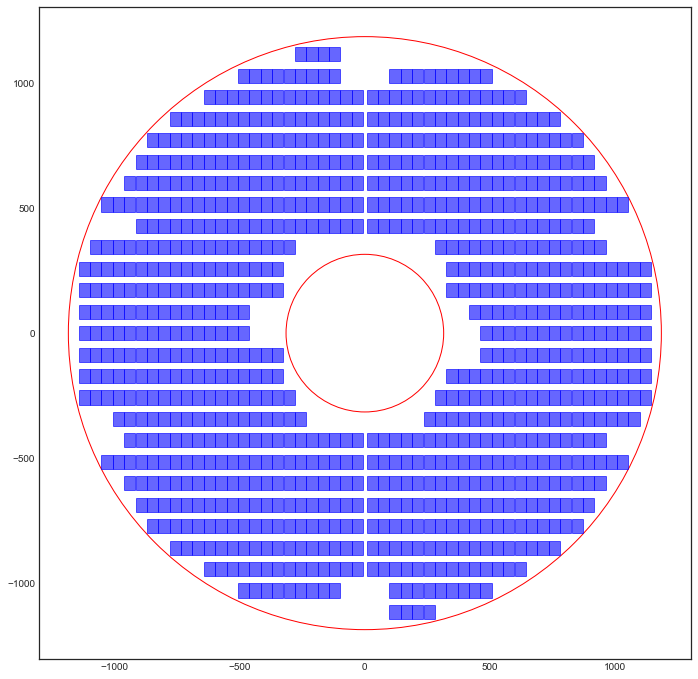

In [48]:
plt.rcParams['figure.figsize'] = [12, 12]

inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)


for x1,y1 in centers2:
    m = Module(height=45,width=56.5,x=x1,y=y1)
    plt.gca().add_patch(m.getPolygon2(color='blue'))

# df = pd.read_csv('data/Face 1.txt',sep='\t')

# # df = df.loc[df['Module '] != 754]
# for x1,y1 in zip(df['X'],df['Y']):
#     x1,y1 = float(x1),float(y1)
#     m = Module(height=43.1,width=56.5,x=x1,y=y1)
#     plt.gca().add_patch(m.getPolygon2(color='red'))
    

# plt.legend(['custom made file', 'original txt'])
# plt.gca().get_legend().legendHandles[0].set_color('blue')

plt.axis('scaled')
# plt.savefig('./new_configs/overlap_2_with_original')
plt.show()

In [14]:
uniques_y = sorted(list(set([y for x,y in output])),reverse=True)
for y in uniques_y:
    coors_per_y = sorted([i[0] for i in filter(lambda x:x[1]==y,output)],reverse=True)
    x = coors_per_y[-1]-43.1-1.075
    x1 = x - 43.1/2
    x2 = x + 43.1/2
    y1 = y - 43.1/2
    y2 = y + 43.1/2
    outline = [
    [x1, y2],
    [x2, y2],
    [x2, y1],
    [x1, y1]
            ]

    if (np.sum(np.square(np.array(outline)),axis=1) < 1185**2).all():
        output.append((x,y))
        output.append((-x,y))
        


    

In [48]:
list(filter(lambda x:x[1]==int_y2[-9],output))

[(939.45, -385.6500000000002),
 (893.95, -385.6500000000002),
 (848.45, -385.6500000000002),
 (802.95, -385.6500000000002),
 (757.45, -385.6500000000002),
 (711.95, -385.6500000000002),
 (666.45, -385.6500000000002),
 (620.95, -385.6500000000002),
 (575.45, -385.6500000000002),
 (529.95, -385.6500000000002),
 (484.45, -385.6500000000002),
 (438.95, -385.6500000000002),
 (393.45, -385.6500000000002),
 (347.95, -385.6500000000002),
 (302.45, -385.6500000000002),
 (256.95, -385.6500000000002),
 (211.45, -385.6500000000002),
 (165.95, -385.6500000000002),
 (120.45, -385.6500000000002),
 (74.95, -385.6500000000002),
 (29.450000000000003, -385.6500000000002),
 (-29.450000000000003, -385.6500000000002),
 (-74.95, -385.6500000000002),
 (-120.45, -385.6500000000002),
 (-165.95, -385.6500000000002),
 (-211.45, -385.6500000000002),
 (-256.95, -385.6500000000002),
 (-302.45, -385.6500000000002),
 (-347.95, -385.6500000000002),
 (-393.45, -385.6500000000002),
 (-438.95, -385.6500000000002),
 (-484.

In [55]:
# list(filter(lambda x:x[1]==uniques_y[-9],output))
# removed = [ (211.45, -385.6500000000002),
#  (165.95, -385.6500000000002), (-211.45, -385.6500000000002),
#  (-256.95, -385.6500000000002)]
removed = [ (-211.45, -385.6500000000002)]
for i in removed:
   output.remove(i)


In [54]:
output.append((-256.95, -385.6500000000002))

In [25]:
# removed = [(252.45000000000005, 1114.1),
#  (207.70000000000005, 1114.1),
#  (162.95000000000005, 1114.1),
#  (118.20000000000003, 1114.1),
#  (73.45000000000003, 1114.1),
#  (28.70000000000003, 1114.1),
#   (-28.70000000000003, 1114.1),
#  (-73.45000000000003, 1114.1),
#  (1057.95, 428.4999999999996),
#  (1013.2, 428.4999999999996),
#   (-1013.2, 428.4999999999996),
#  (-1057.95, 428.4999999999996),
#  (1102.7, 342.7999999999996),
#  (1057.95, 342.7999999999996),
#  (1013.2, 342.7999999999996),
#  (252.45000000000005, 342.7999999999996),
#  (207.70000000000005, 342.7999999999996),
#  (162.95000000000005, 342.7999999999996),
#  (118.20000000000003, 342.7999999999996),
#  (73.45000000000003, 342.7999999999996),
#  (-73.45000000000003, 342.7999999999996),
#  (-118.20000000000003, 342.7999999999996),
#  (-162.95000000000005, 342.7999999999996),
#  (-207.70000000000005, 342.7999999999996),
#  (-252.45000000000005, 342.7999999999996), 
#  (-1102.7, 342.7999999999996),
#  (252.45000000000005, 257.0999999999996),
#  (-252.45000000000005, 257.0999999999996), 
#  (341.95000000000005, 85.69999999999963),
#  (-341.95000000000005, 85.69999999999963),
#  (-386.70000000000005, 85.69999999999963),
#  (-431.45000000000005, 85.69999999999963),
#  (431.45000000000005, -3.694822225952521e-13),
#  (386.70000000000005, -3.694822225952521e-13),
#  (341.95000000000005, -3.694822225952521e-13),
#  (-341.95000000000005, -3.694822225952521e-13),
#  (-386.70000000000005, -3.694822225952521e-13),
#  (-431.45000000000005, -3.694822225952521e-13),
#  (431.45000000000005, -85.70000000000037),
#  (386.70000000000005, -85.70000000000037),
#  (341.95000000000005, -85.70000000000037),
#  (-341.95000000000005, -85.70000000000037),
#  (252.45000000000005, -257.10000000000036),
#  (-252.45000000000005, -257.10000000000036),
#   (252.45000000000005, -342.80000000000035),
#  (207.70000000000005, -342.80000000000035),
#  (162.95000000000005, -342.80000000000035),
#  (118.20000000000003, -342.80000000000035),
#  (73.45000000000003, -342.80000000000035),
#  (-73.45000000000003, -342.80000000000035),
#  (-118.20000000000003, -342.80000000000035),
#  (-162.95000000000005, -342.80000000000035),
#  (-207.70000000000005, -342.80000000000035),
#  (-252.45000000000005, -342.80000000000035),
#  (-968.45, -342.80000000000035),
#  (-1013.2, -342.80000000000035),
#  (-1057.95, -342.80000000000035),
#  (-1102.7, -342.80000000000035),
#  (1057.95, -428.50000000000034),
#  (1013.2, -428.50000000000034),
#  (968.45, -428.50000000000034),
# (-968.45, -428.50000000000034),
#  (-1013.2, -428.50000000000034),
#  (-1057.95, -428.50000000000034),
#   (73.45000000000003, -1114.1000000000006),
#  (28.70000000000003, -1114.1000000000006),
#  (-28.70000000000003, -1114.1000000000006),
#  (-73.45000000000003, -1114.1000000000006),
#  (-118.20000000000003, -1114.1000000000006),
#  (-162.95000000000005, -1114.1000000000006),
#  (-207.70000000000005, -1114.1000000000006),
#  (-252.45000000000005, -1114.1000000000006),
#   (-386.70000000000005, -1028.4000000000005),
#  (-431.45000000000005, -1028.4000000000005),
#  (-476.20000000000005, -1028.4000000000005)]

removed = [(-27.550000000000033, 1114.1),
 (-71.72500000000004, 1114.1),
 (-115.90000000000003, 1114.1), (115.90000000000003, 1114.1),
 (71.72500000000004, 1114.1),
 (27.550000000000033, 1114.1), (71.72500000000004, 1028.3999999999999),
 (27.550000000000033, 1028.3999999999999),
 (-27.550000000000033, 1028.3999999999999),
 (-71.72500000000004, 1028.3999999999999),(1043.5749999999996, 428.4999999999996),
 (999.3999999999996, 428.4999999999996), (-999.3999999999996, 428.4999999999996),
 (-1043.5749999999996, 428.4999999999996), (160.07500000000005, 342.7999999999996),
 (115.90000000000003, 342.7999999999996),
 (71.72500000000004, 342.7999999999996), (248.42500000000007, 342.7999999999996),
 (204.25000000000006, 342.7999999999996),(-71.72500000000004, 342.7999999999996),
 (-115.90000000000003, 342.7999999999996),
 (-160.07500000000005, 342.7999999999996),
 (-204.25000000000006, 342.7999999999996),
 (-248.42500000000007, 342.7999999999996),(248.42500000000007, 257.0999999999996),
 (-248.42500000000007, 257.0999999999996),(336.7750000000001, 85.69999999999963),
 (-336.7750000000001, 85.69999999999963),
 (-380.9500000000001, 85.69999999999963),
 (-425.1250000000001, 85.69999999999963), (425.1250000000001, -3.694822225952521e-13),
 (380.9500000000001, -3.694822225952521e-13),
 (336.7750000000001, -3.694822225952521e-13),
 (-336.7750000000001, -3.694822225952521e-13),
 (-380.9500000000001, -3.694822225952521e-13),
 (-425.1250000000001, -3.694822225952521e-13), (425.1250000000001, -85.70000000000037),
 (380.9500000000001, -85.70000000000037),
 (336.7750000000001, -85.70000000000037),
 (-336.7750000000001, -85.70000000000037), (248.42500000000007, -257.10000000000036),
 (-248.42500000000007, -257.10000000000036), (248.42500000000007, -342.80000000000035),
 (204.25000000000006, -342.80000000000035),
 (160.07500000000005, -342.80000000000035),
 (115.90000000000003, -342.80000000000035),
 (71.72500000000004, -342.80000000000035),
 (-71.72500000000004, -342.80000000000035),
 (-115.90000000000003, -342.80000000000035),
 (-160.07500000000005, -342.80000000000035),
 (-204.25000000000006, -342.80000000000035),
 (-248.42500000000007, -342.80000000000035), (1043.5749999999996, -428.50000000000034),
 (999.3999999999996, -428.50000000000034), (-999.3999999999996, -428.50000000000034),
 (-1043.5749999999996, -428.50000000000034), (1087.7499999999995, 342.7999999999996),
 (1043.5749999999996, 342.7999999999996),
 (999.3999999999996, 342.7999999999996), (-999.3999999999996, -342.80000000000035),
 (-1043.5749999999996, -342.80000000000035),
 (-1087.7499999999995, -342.80000000000035), (71.72500000000004, -1114.1000000000006),
 (27.550000000000033, -1114.1000000000006), (-71.72500000000004, -1114.1000000000006),
 (-27.550000000000033, -1114.1000000000006), (71.72500000000004, -1028.4000000000005),
 (27.550000000000033, -1028.4000000000005),
 (-27.550000000000033, -1028.4000000000005),
 (-71.72500000000004, -1028.4000000000005),(-160.07500000000005, 428.4999999999996),
 (-204.25000000000006, 428.4999999999996),(204.25000000000006, -428.50000000000034),
 (160.07500000000005, -428.50000000000034)]
for i in removed:
   centers2.remove(i)

In [22]:
centers2.sort(key=lambda x:[x[1],x[0]],reverse=True)
centers2

[(252.45000000000005, 1114.1),
 (207.70000000000005, 1114.1),
 (162.95000000000005, 1114.1),
 (118.20000000000003, 1114.1),
 (73.45000000000003, 1114.1),
 (28.70000000000003, 1114.1),
 (-28.70000000000003, 1114.1),
 (-73.45000000000003, 1114.1),
 (-118.20000000000003, 1114.1),
 (-162.95000000000005, 1114.1),
 (-207.70000000000005, 1114.1),
 (-252.45000000000005, 1114.1),
 (476.20000000000005, 1028.3999999999999),
 (431.45000000000005, 1028.3999999999999),
 (386.70000000000005, 1028.3999999999999),
 (341.95000000000005, 1028.3999999999999),
 (297.20000000000005, 1028.3999999999999),
 (252.45000000000005, 1028.3999999999999),
 (207.70000000000005, 1028.3999999999999),
 (162.95000000000005, 1028.3999999999999),
 (118.20000000000003, 1028.3999999999999),
 (73.45000000000003, 1028.3999999999999),
 (28.70000000000003, 1028.3999999999999),
 (-28.70000000000003, 1028.3999999999999),
 (-73.45000000000003, 1028.3999999999999),
 (-118.20000000000003, 1028.3999999999999),
 (-162.95000000000005, 10

In [24]:
sorted(list(set([i[1] for i in centers2])),reverse=True)

[1114.1,
 1028.3999999999999,
 942.6999999999998,
 856.9999999999998,
 771.2999999999997,
 685.5999999999997,
 599.8999999999996,
 514.1999999999996,
 428.4999999999996,
 342.7999999999996,
 257.0999999999996,
 171.39999999999964,
 85.69999999999963,
 -3.694822225952521e-13,
 -85.70000000000037,
 -171.40000000000038,
 -257.10000000000036,
 -342.80000000000035,
 -428.50000000000034,
 -514.2000000000004,
 -599.9000000000004,
 -685.6000000000005,
 -771.3000000000005,
 -857.0000000000006,
 -942.7000000000006,
 -1028.4000000000005,
 -1114.1000000000006]

In [49]:
output2 = list(filter(lambda x:x[0]<0,output))
y_s = sorted(list(set([i[1] for i in output2])),reverse=True)
y_s

[1071.25,
 985.55,
 899.8499999999999,
 814.1499999999999,
 728.4499999999998,
 642.7499999999998,
 557.0499999999997,
 471.34999999999974,
 385.64999999999975,
 299.94999999999976,
 214.24999999999977,
 128.54999999999978,
 42.84999999999978,
 -42.85000000000022,
 -128.55000000000024,
 -214.25000000000023,
 -299.9500000000002,
 -385.6500000000002,
 -471.3500000000002,
 -557.0500000000002,
 -642.7500000000002,
 -728.4500000000003,
 -814.1500000000003,
 -899.8500000000004,
 -985.5500000000004,
 -1071.2500000000005]

In [50]:
unchanged = [8,9,18,19]

for i in range(len(y_s)):
    if i+1 not in unchanged:
        filtered = list(filter(lambda x:x[1]==y_s[i],output2))
        filtered = sorted(filtered,key=lambda x:x[0],reverse=True)
        x_lhs = filtered[-1][0]
        x,y = x_lhs-44.25-0.5, y_s[i]
        x1 = x - 44.25/2
        x2 = x + 44.25/2
        y1 = y - 56.5/2
        y2 = y + 56.5/2
        outline = [
        [x1, y2],
        [x2, y2],
        [x2, y1],
        [x1, y1]
                ]
        
        if (np.sum(np.square(np.array(outline)),axis=1) < 1185**2).all():
            print('yay')
            output2.append((x,y))

        else:
            print((np.sum(np.square(np.array(outline)),axis=1)))


yay
yay
yay
yay
yay
[1431479.830625 1345772.005625 1273141.255625 1358849.080625]
[1414473.945625 1324805.745625 1261859.095625 1351527.295625]
yay
yay
yay
yay
yay
yay
yay
yay
[1351527.295625 1261859.095625 1324805.745625 1414473.945625]
yay
yay
yay
yay
yay
yay


In [57]:
output3 = []
for x,y in output2:
    output3.append((x,y))
    output3.append((-x,y))

In [55]:
output2.sort(key=lambda x:[x[1],x[0]], reverse=True)
output2

[(-118.2, 1071.25),
 (-162.95, 1071.25),
 (-207.7, 1071.25),
 (-252.45, 1071.25),
 (-297.2, 1071.25),
 (-341.95, 1071.25),
 (-386.7, 1071.25),
 (-28.700000000000003, 985.55),
 (-73.45, 985.55),
 (-118.2, 985.55),
 (-162.95, 985.55),
 (-207.7, 985.55),
 (-252.45, 985.55),
 (-297.2, 985.55),
 (-341.95, 985.55),
 (-386.7, 985.55),
 (-431.45, 985.55),
 (-476.2, 985.55),
 (-520.95, 985.55),
 (-565.7, 985.55),
 (-28.700000000000003, 899.8499999999999),
 (-73.45, 899.8499999999999),
 (-118.2, 899.8499999999999),
 (-162.95, 899.8499999999999),
 (-207.7, 899.8499999999999),
 (-252.45, 899.8499999999999),
 (-297.2, 899.8499999999999),
 (-341.95, 899.8499999999999),
 (-386.7, 899.8499999999999),
 (-431.45, 899.8499999999999),
 (-476.2, 899.8499999999999),
 (-520.95, 899.8499999999999),
 (-565.7, 899.8499999999999),
 (-610.45, 899.8499999999999),
 (-655.2, 899.8499999999999),
 (-699.95, 899.8499999999999),
 (-28.700000000000003, 814.1499999999999),
 (-73.45, 814.1499999999999),
 (-118.2, 814.14999

In [56]:
output2.remove((-162.95, -385.6500000000002))
output2.remove((-207.7, -385.6500000000002))

In [49]:
df = pd.DataFrame(centers2,columns=['X','Y'])

In [58]:
df.to_csv('Face 2 and 4_4')

In [13]:
df = pd.read_csv('new_configs/Face 2 and 4')

In [14]:
centers2 = list(zip(df['X'],df['Y']))